# SWAG MCQ Reasoning with BERT and In-Context Learning

This notebook implements **Task 3** from the *Introduction to Data Science - Assignment 5&6*. The goal is to explore how **Large Language Models (LLMs)**, specifically BERT, can solve **multiple-choice commonsense reasoning questions** from the **SWAG dataset**.

Traditional machine learning models struggle with nuanced semantic inference tasks. Here, we utilize modern LLM techniques—including **zero-shot prediction**, **in-context learning (ICL)**, and **fine-tuning with LoRA**—to handle the task effectively.

### 🔍 Task Overview
We work with the **SWAG dataset** (113k+ MCQs) to:
- Preprocess and tokenize inputs in multiple-choice format.
- Evaluate BERT in a zero-shot setting.
- Apply in-context learning using prompt engineering.
- Fine-tune the BERT model with LoRA for performance gains.
- Compare model performance across zero-shot, ICL, and fine-tuned configurations.

### 🧠 Learning Objective
- Understand the limitations of classical models for reasoning tasks.
- Apply prompt-based and fine-tuning strategies for LLMs.
- Use HuggingFace Transformers to load, preprocess, evaluate, and fine-tune models.
- Analyze results using accuracy, confusion matrix, and perplexity.

**Dataset:** [SWAG - Situations With Adversarial Generations](https://huggingface.co/datasets/allenai/swag)
            
### 📌 Note
Make sure to
- Use your Hugging Face token for access.
- Run on Kaggle for reliable GPU access and smoother performance. 


In [1]:
# # 1) Uninstall any leftovers
# !pip uninstall -y transformers tokenizers

# # 2) Install the last version before the helpers were removed
# !pip install --no-cache-dir transformers==4.27.4

# # 3) Now install your other libraries (they won’t bump Transformers because 4.27.4 satisfies PEFT)
# !pip install --no-cache-dir peft evaluate packaging


In [2]:
# !pip uninstall -y transformers tokenizers datasets fsspec peft evaluate

In [3]:
import transformers, datasets, fsspec, peft
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("Fsspec:", fsspec.__version__)
print("PEFT:", peft.__version__)


2025-08-24 10:47:46.965133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756032466.988753     180 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756032466.995820     180 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Transformers: 4.52.4
Datasets: 3.6.0
Fsspec: 2025.3.0
PEFT: 0.15.2


In [4]:
# !pip uninstall -y transformers
# !pip install transformers==4.27.4 --no-cache-dir



In [5]:
# import transformers
# print(transformers.__version__)

In [6]:
print("hello world")

hello world


## 1. Hugging Face Access Token

In [ ]:
# Hugging Face Login
from huggingface_hub import notebook_login, login
notebook_login()


## 2. Loading Dataset

In [8]:
from datasets import load_dataset
import pandas as pd

# Load the SWAG dataset
dataset = load_dataset("swag", "regular")

df_train = dataset['train'].to_pandas()
df_val = dataset['validation'].to_pandas()
df_test = dataset['test'].to_pandas()

# adding a column to specify the split
df_train['split'] = 'train'
df_val['split'] = 'validation'
df_test['split'] = 'test'
# Concatenate all into one DataFrame
df = pd.concat([df_train, df_val, df_test], ignore_index=True)

print(dataset)
dataset["train"][0]
  

DatasetDict({
    train: Dataset({
        features: ['video-id', 'fold-ind', 'startphrase', 'sent1', 'sent2', 'gold-source', 'ending0', 'ending1', 'ending2', 'ending3', 'label'],
        num_rows: 73546
    })
    validation: Dataset({
        features: ['video-id', 'fold-ind', 'startphrase', 'sent1', 'sent2', 'gold-source', 'ending0', 'ending1', 'ending2', 'ending3', 'label'],
        num_rows: 20006
    })
    test: Dataset({
        features: ['video-id', 'fold-ind', 'startphrase', 'sent1', 'sent2', 'gold-source', 'ending0', 'ending1', 'ending2', 'ending3', 'label'],
        num_rows: 20005
    })
})


{'video-id': 'anetv_jkn6uvmqwh4',
 'fold-ind': '3416',
 'startphrase': 'Members of the procession walk down the street holding small horn brass instruments. A drum line',
 'sent1': 'Members of the procession walk down the street holding small horn brass instruments.',
 'sent2': 'A drum line',
 'gold-source': 'gold',
 'ending0': 'passes by walking down the street playing their instruments.',
 'ending1': 'has heard approaching them.',
 'ending2': "arrives and they're outside dancing and asleep.",
 'ending3': 'turns the lead singer watches the performance.',
 'label': 0}

## 3. Analyza the Dataset

### schema

In [9]:
df.head(4)

,video-id,fold-ind,startphrase,sent1,sent2,gold-source,ending0,ending1,ending2,ending3,label,split
0,anetv_jkn6uvmqwh4,3416,Members of the procession walk down the street...,Members of the procession walk down the street...,A drum line,gold,passes by walking down the street playing thei...,has heard approaching them.,arrives and they're outside dancing and asleep.,turns the lead singer watches the performance.,0,train
1,anetv_jkn6uvmqwh4,3417,A drum line passes by walking down the street ...,A drum line passes by walking down the street ...,Members of the procession,gen,are playing ping pong and celebrating one left...,wait slowly towards the cadets.,continues to play as well along the crowd alon...,"continue to play marching, interspersed.",3,train
2,anetv_jkn6uvmqwh4,3415,A group of members in green uniforms walks wav...,A group of members in green uniforms walks wav...,Members of the procession,gold,pay the other coaches to cheer as people this ...,walk down the street holding small horn brass ...,is seen in the background.,are talking a couple of people playing a game ...,1,train
3,anetv_jkn6uvmqwh4,3417,A drum line passes by walking down the street ...,A drum line passes by walking down the street ...,Members of the procession,gen,are playing ping pong and celebrating one left...,wait slowly towards the cadets.,makes a square call and ends by jumping down i...,play and go back and forth hitting the drums w...,3,train


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113557 entries, 0 to 113556
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   video-id     113557 non-null  object
 1   fold-ind     113557 non-null  object
 2   startphrase  113557 non-null  object
 3   sent1        113557 non-null  object
 4   sent2        113557 non-null  object
 5   gold-source  113557 non-null  object
 6   ending0      113557 non-null  object
 7   ending1      113557 non-null  object
 8   ending2      113557 non-null  object
 9   ending3      113557 non-null  object
 10  label        113557 non-null  int64 
 11  split        113557 non-null  object
dtypes: int64(1), object(11)
memory usage: 10.4+ MB


In [11]:
df.describe(include='all')

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,video-id,fold-ind,startphrase,sent1,sent2,gold-source,ending0,ending1,ending2,ending3,label,split
count,113557,113557,113557,113557,113557,113557,113557,113557,113557,113557,113557.000000,113557
unique,21615,20083,92221,91712,26602,2,108368,108270,108234,108490,NaN,3
top,lsmdc3047_LIFE_OF_PI-22387,8191,We see an opening title screen. We,We see an opening title screen.,Someone,gold,see the ending title screen.,talks to the camera.,talks to the camera.,talks to the camera.,NaN,train
freq,211,13,52,94,19005,87939,33,35,31,31,NaN,73546
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.061194,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.392450,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN


### Class distributions

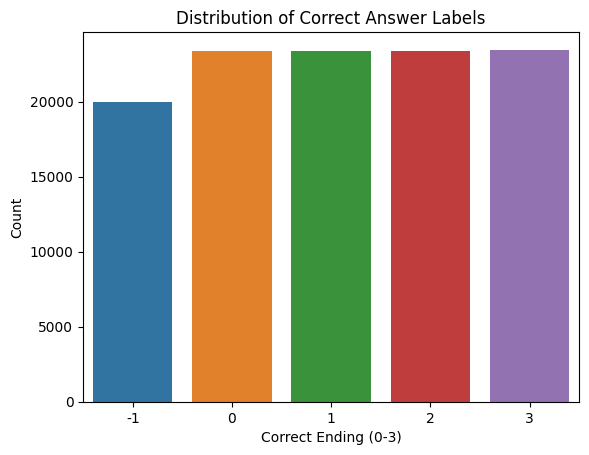

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='label', data=df)
plt.title("Distribution of Correct Answer Labels")
plt.xlabel("Correct Ending (0-3)")
plt.ylabel("Count")
plt.show()
 

### Avg length of sent1, sent2, ending

In [13]:
df['sent1_len'] = df['sent1'].apply(lambda x: len(x.split()))
df['sent2_len'] = df['sent2'].apply(lambda x: len(x.split()))
for i in range(4):
    df[f'ending{i}_len'] = df[f'ending{i}'].apply(lambda x: len(x.split()))
    
# Display averages
print("Average lengths:")
print(f"sent1: {df['sent1_len'].mean():.2f} words")
print(f"sent2: {df['sent2_len'].mean():.2f} words")
for i in range(4):
    print(f"ending{i}: {df[f'ending{i}_len'].mean():.2f} words")
    
# Display max
print("Max lengths:")
print(f"sent1: {df['sent1_len'].max():.2f} words")
print(f"sent2: {df['sent2_len'].max():.2f} words")
for i in range(4):    
    print(f"ending{i}: {df[f'ending{i}_len'].max():.2f} words")
  

Average lengths:
sent1: 11.54 words
sent2: 2.70 words
ending0: 8.67 words
ending1: 8.69 words
ending2: 8.66 words
ending3: 8.65 words
Max lengths:
sent1: 74.00 words
sent2: 76.00 words
ending0: 25.00 words
ending1: 25.00 words
ending2: 25.00 words
ending3: 25.00 words


### One full mcq example

In [14]:
i = 0
print("sent1:", df.loc[i, 'sent1'])
print("sent2:", df.loc[i, 'sent2'])
for j in range(4):
    print(f"ending{j}:", df.loc[i, f'ending{j}'])
    print("Correct label:", df.loc[i, 'label'])
  

sent1: Members of the procession walk down the street holding small horn brass instruments.
sent2: A drum line
ending0: passes by walking down the street playing their instruments.
Correct label: 0
ending1: has heard approaching them.
Correct label: 0
ending2: arrives and they're outside dancing and asleep.
Correct label: 0
ending3: turns the lead singer watches the performance.
Correct label: 0


## 4. Load Tokenizer

In [15]:
from transformers import AutoTokenizer
# loading tokenizer
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")  

## 5. Pre-Process the Dataset

In [50]:
def preprocess_swag(batch):
    first_sentences = [s1 for s1 in batch['sent1'] for _ in range(4)]
    second_sentences = [
        batch['sent2'][i] + " " + batch[f'ending{j}'][i]
        for i in range(len(batch['sent1']))
        for j in range(4)
    ]
    
    tokenized = tokenizer(
        first_sentences,
        second_sentences,
        truncation=True,
        padding="longest"
        )
    # Unflatten: group every 4 items as a list
    def regroup(values):
        return [values[i:i + 4] for i in range(0, len(values), 4)]
    
    return {key: regroup(val) for key, val in tokenized.items()}



## 6. Apply the preprocessing function

In [51]:
# Apply preprocessing function with batch
tokenized_dataset = {
    split: dataset[split].map(preprocess_swag, batched=True)
    for split in ["train", "validation", "test"]
}
  

Map:   0%|          | 0/73546 [00:00<?, ? examples/s]

Map:   0%|          | 0/20006 [00:00<?, ? examples/s]

Map:   0%|          | 0/20005 [00:00<?, ? examples/s]

In [53]:
# clean and finalize the dataset
for split in ["train", "validation", "test"]:
    if "label" in tokenized_dataset[split].column_names:
        tokenized_dataset[split] = tokenized_dataset[split].rename_column("label", "labels")
        
        keep_cols = ['input_ids', 'attention_mask', 'token_type_ids', 'labels']
        tokenized_dataset[split] = tokenized_dataset[split].remove_columns(
            [col for col in tokenized_dataset[split].column_names if col not in keep_cols]
        )    

## 7. Padding

In [19]:
from transformers.data.data_collator import DataCollatorForMultipleChoice

data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)


## 8. Load Model

In [20]:
from transformers import AutoModelForMultipleChoice

model = AutoModelForMultipleChoice.from_pretrained("google-bert/bert-base-uncased") 

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 9. Test Model on Dataset

In [21]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# This will store (method, accuracy)
icl_results = []

### Test case analysis

In [22]:
import torch

# Device setup (should match your model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Pick a single example to inspect
i = 0  # You can change this index to test other samples
example = tokenized_dataset["validation"][i]
raw_example = dataset["validation"][i]  # un-tokenized version for readable display

# Convert inputs to tensor format (batch size = 1) and move to device
input = {
    k: torch.tensor([example[k]]).to(device)
    for k in ["input_ids", "attention_mask", "token_type_ids"]
}

# Run the model and get prediction
model.eval()
with torch.no_grad():
    outputs = model(**input)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

# Display the context
context = raw_example["sent1"] + " " + raw_example["sent2"]
print(f"📌 Context: {context}")

# Display all choices with prediction and ground truth
print("🔘 Options:")
for j in range(4):
    option_text = raw_example[f"ending{j}"]
    prefix = "✅" if j == raw_example["label"] else "❌"
    marker = "👉" if j == predicted_class else "  "
    print(f"{marker} {prefix} Choice {j}: {option_text}")

# Final Summary
print(f"🧠 Model Prediction: Choice {predicted_class}")
print(f"✔️ Ground Truth: Choice {raw_example['label']}")


📌 Context: Students lower their eyes nervously. She
🔘 Options:
   ❌ Choice 0: pats her shoulder, then saunters toward someone.
   ❌ Choice 1: turns with two students.
   ✅ Choice 2: walks slowly towards someone.
👉 ❌ Choice 3: wheels around as her dog thunders out.
🧠 Model Prediction: Choice 3
✔️ Ground Truth: Choice 2


### Full valildation set evaluation

In [23]:
val_loader = DataLoader(
    tokenized_dataset["validation"],
    batch_size=16,
    collate_fn=data_collator)

model.eval()
correct = 0
total = 0

for batch in tqdm(val_loader, desc="Evaluating Baseline"):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == batch["labels"]).sum().item()
        total += batch["labels"].size(0)
        
baseline_acc = 100*(correct / total)
print(f"📊 Baseline Accuracy: {baseline_acc:.2f}%")
icl_results.append(("Baseline (No ICL)", baseline_acc))
   

Evaluating Baseline: 100%|██████████| 1251/1251 [03:45<00:00,  5.56it/s]

📊 Baseline Accuracy: 39.16%


## 10. In-Context Learning

### Few-shot

In [24]:
from transformers import AutoModelForMultipleChoice
import torch
from torch.utils.data import DataLoader
from transformers import DataCollatorForMultipleChoice
from datasets import Dataset
from tqdm import tqdm


# Select 5-shot ICL examples from validation set
fewshot_indices = [0, 1, 2, 3, 4]
fewshot_examples = [dataset["validation"][i] for i in fewshot_indices]

# Build the static few-shot prompt
fewshot_prompt = ""
for ex in fewshot_examples:
    fewshot_prompt += f"Context: {ex['sent1']} {ex['sent2']}\n"
    for j in range(4):
        fewshot_prompt += f"{chr(65+j)}. {ex[f'ending{j}']}\n"
    fewshot_prompt += f"Answer: {chr(65 + ex['label'])}\n\n"


In [25]:
# Define the ICL preprocessing function
def preprocess_fewshot_icl_batch(batch):
    prompts = []
    first_sentences = []
    second_sentences = []

    for i in range(len(batch['sent1'])):
        prompt = fewshot_prompt + f"\nContext: {batch['sent1'][i]} {batch['sent2'][i]}"
        first_sentences.extend([prompt] * 4)
        second_sentences.extend([
            f"{chr(65 + j)}. {batch[f'ending{j}'][i]}" for j in range(4)
        ])

    # print(first_sentences)
    # print(second_sentences)
    tokenized = tokenizer(first_sentences, second_sentences, truncation=True, padding="longest")

    def regroup(values): return [values[i:i+4] for i in range(0, len(values), 4)]
    result = {k: regroup(v) for k, v in tokenized.items()}
    result["labels"] = batch["label"]
    return result


In [26]:
fewshot_icl_dataset = dataset["validation"].map(preprocess_fewshot_icl_batch, batched=True)

In [27]:
# 1) Clean & finalize the few-shot ICL dataset

# If the old 'label' column still exists, drop it\nif "label" in fewshot_icl_dataset.column_names:
fewshot_icl_dataset = fewshot_icl_dataset.remove_columns(["label"])

# Now keep only the required MCQ fields plus 'labels'
keep_cols = ["input_ids", "attention_mask", "token_type_ids", "labels"]
fewshot_icl_dataset = fewshot_icl_dataset.remove_columns(
    [c for c in fewshot_icl_dataset.column_names if c not in keep_cols]
)     

In [28]:
# 2) Create DataLoader with your MCQ collator
fewshot_icl_loader = DataLoader(
    fewshot_icl_dataset,
    batch_size=8,
    collate_fn=data_collator
)

# 3) Evaluate Few-Shot ICL
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for batch in tqdm(fewshot_icl_loader, desc="Evaluating Few-Shot ICL"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == batch["labels"]).sum().item()
        total += batch["labels"].size(0)
    
few_shot_accuracy = 100*(correct / total)
print(f"📊 Few-Shot ICL Accuracy: {few_shot_accuracy:.2f}%")
icl_results.append(("Few shot learning (ICL)", few_shot_accuracy))
    

Evaluating Few-Shot ICL: 100%|██████████| 2501/2501 [20:05<00:00,  2.08it/s]

📊 Few-Shot ICL Accuracy: 37.66%


### Zero-shot with chain of thought (COT)

In [29]:
# 1) Build the CoT prompt prefix
cot_prefix = "Let's think step by step.\n\n"

In [30]:
# 2) Define the CoT preprocessing fn
def preprocess_cot_batch(batch):
    first_sentences = []
    second_sentences = []

    for i in range(len(batch["sent1"])):
        # prepend the chain-of-thought instruction before each example
        prompt = cot_prefix + f"Context: {batch['sent1'][i]} {batch['sent2'][i]}"
        # repeat for the 4 choices
        first_sentences.extend([prompt] * 4)
        second_sentences.extend([
            f"{chr(65 + j)}. {batch[f'ending{j}'][i]}" for j in range(4)
        ])

    # tokenize exactly as before
    tokenized = tokenizer(first_sentences, second_sentences,
                          truncation=True, padding="longest")

    # regroup back into (batch_size, 4, seq_len)
    def regroup(vals): return [vals[i : i + 4] for i in range(0, len(vals), 4)]
    result = {k: regroup(v) for k, v in tokenized.items()}
    # carry label forward
    result["labels"] = batch["label"]
    return result


In [31]:
# 3) Map over validation set
cot_dataset = dataset["validation"].map(
    preprocess_cot_batch,
    batched=True,
    remove_columns=dataset["validation"].column_names  # drop raw cols
)


In [32]:
# 4) Clean up columns (drop old 'label' if still there)
if "label" in cot_dataset.column_names:
    cot_dataset = cot_dataset.remove_columns(["label"])
keep = ["input_ids", "attention_mask", "token_type_ids", "labels"]
cot_dataset = cot_dataset.remove_columns(
    [c for c in cot_dataset.column_names if c not in keep]
)

In [33]:
# 5) Create a DataLoader
cot_loader = DataLoader(
    cot_dataset,
    batch_size=8,
    collate_fn=data_collator
)

# 6) Evaluate Zero-Shot CoT
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for batch in tqdm(cot_loader, desc="Evaluating Zero-Shot CoT"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == batch["labels"]).sum().item()
        total += batch["labels"].size(0)

cot_accuracy = 100*(correct / total)
print(f"\n📊 Zero-Shot CoT Accuracy: {cot_accuracy:.2f}%")
icl_results.append(("Chain of Thought (ICL)", cot_accuracy))


Evaluating Zero-Shot CoT: 100%|██████████| 2501/2501 [04:17<00:00,  9.72it/s]


📊 Zero-Shot CoT Accuracy: 40.08%


### Comparison table

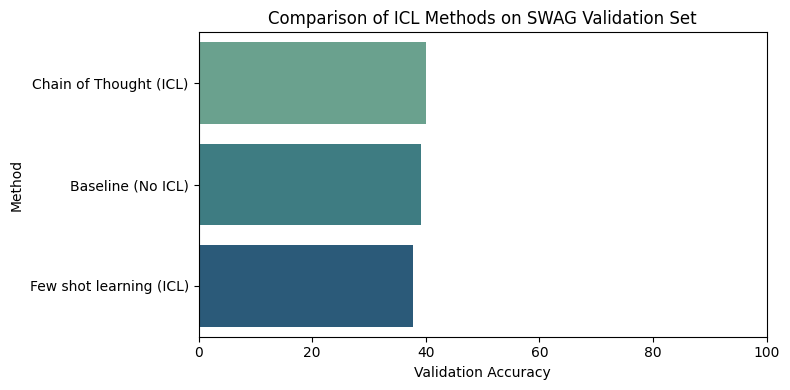

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

comparison_df = pd.DataFrame(icl_results, columns=["Method", "Accuracy"])
comparison_df = comparison_df.sort_values("Accuracy", ascending=False).reset_index(drop=True)

plt.figure(figsize=(8, 4))
sns.barplot(data=comparison_df, x="Accuracy", y="Method", palette="crest")
plt.title("Comparison of ICL Methods on SWAG Validation Set")
plt.xlim(0, 100)
plt.xlabel("Validation Accuracy")
plt.tight_layout()
plt.show()


## 11. Fine-Tune Bert

In [35]:
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer, SchedulerType
from peft       import LoraConfig, get_peft_model, TaskType
import numpy    as np
from evaluate   import load


In [36]:
train_ds = tokenized_dataset["train"]
eval_ds  = tokenized_dataset["validation"]

base_model = model
base_model.to(device)

# Config (wrap bert with lora)
lora_cfg = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS,
)
model_with_lora = get_peft_model(base_model, lora_cfg)


### Fine-tuning loop

In [37]:
# Fine-tune visible progress (Transformers 4.47 compatible)

import os
import numpy as np
from evaluate import load
from transformers import (
    TrainingArguments, Trainer,
    IntervalStrategy, SchedulerType,
    TrainerCallback,
)
from transformers.utils import logging as hf_logging

# Make logs visible in the cell; silence wandb noise
hf_logging.set_verbosity_info()
os.environ["WANDB_DISABLED"] = "true"   # or: os.environ["WANDB_MODE"] = "offline"

# Metrics
accuracy_metric = load("accuracy")
def compute_metrics(pred):
    labels = pred.label_ids
    preds  = np.argmax(pred.predictions, axis=1)
    return accuracy_metric.compute(predictions=preds, references=labels)

# Training arguments (step-level eval/save + frequent logging)
training_args = TrainingArguments(
    output_dir="swag_lora_ft",

    do_eval=True,
    eval_strategy=IntervalStrategy.STEPS,   # 4.47 naming
    eval_steps=500,
    save_strategy=IntervalStrategy.STEPS,
    save_steps=500,
    save_total_limit=2,

    learning_rate=4e-5,
    warmup_ratio=0.1,
    lr_scheduler_type=SchedulerType.LINEAR,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    num_train_epochs=2,

    # visible logs / progress
    logging_strategy=IntervalStrategy.STEPS,
    logging_steps=50,         # print every 50 steps
    disable_tqdm=False,       # show progress bar
    report_to="none",         # no wandb/tensorboard

    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Tiny callback to guarantee prints even if buffering happens
class PrintCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            print(f"[step {state.global_step}] {logs}")

# Trainer (reuses your existing objects: model_with_lora, train_ds, eval_ds, data_collator, tokenizer)
trainer = Trainer(
    model=model_with_lora,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    data_collator=data_collator,
    tokenizer=tokenizer,          # ok; may show a future deprecation warning
    compute_metrics=compute_metrics,
    callbacks=[PrintCallback()],
)

# Train
trainer.train()


PyTorch: setting up devices
/tmp/ipykernel_180/302647636.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
***** Running training *****
  Num examples = 73,546
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 3,450
  Number of trainable parameters = 295,681


Step,Training Loss,Validation Loss,Accuracy
500,1.008200,0.855875,0.660702
1000,0.932700,0.776682,0.698640
1500,0.896100,0.743415,0.711836
2000,0.895900,0.721652,0.718085
2500,0.876900,0.708561,0.725132
3000,0.855200,0.701657,0.727882


[step 50] {'loss': 1.386, 'grad_norm': 1.5575599670410156, 'learning_rate': 5.681159420289856e-06, 'epoch': 0.04350663476180117}
[step 100] {'loss': 1.3871, 'grad_norm': 1.056244969367981, 'learning_rate': 1.1478260869565218e-05, 'epoch': 0.08701326952360235}
[step 150] {'loss': 1.3743, 'grad_norm': 0.960759162902832, 'learning_rate': 1.727536231884058e-05, 'epoch': 0.13051990428540353}
[step 200] {'loss': 1.3534, 'grad_norm': 1.1196753978729248, 'learning_rate': 2.3072463768115943e-05, 'epoch': 0.1740265390472047}
[step 250] {'loss': 1.3077, 'grad_norm': 0.9742984175682068, 'learning_rate': 2.8869565217391307e-05, 'epoch': 0.2175331738090059}
[step 300] {'loss': 1.1986, 'grad_norm': 2.568655490875244, 'learning_rate': 3.466666666666667e-05, 'epoch': 0.26103980857080705}
[step 350] {'loss': 1.1444, 'grad_norm': 1.5619215965270996, 'learning_rate': 3.994847020933978e-05, 'epoch': 0.3045464433326082}
[step 400] {'loss': 1.054, 'grad_norm': 2.419137477874756, 'learning_rate': 3.9304347826


***** Running Evaluation *****
  Num examples = 20006
  Batch size = 16


[step 500] {'loss': 1.0082, 'grad_norm': 2.427065372467041, 'learning_rate': 3.801610305958132e-05, 'epoch': 0.4350663476180118}
[step 500] {'eval_loss': 0.8558745980262756, 'eval_accuracy': 0.660701789463161, 'eval_runtime': 235.1985, 'eval_samples_per_second': 85.06, 'eval_steps_per_second': 5.319, 'epoch': 0.4350663476180118}


Saving model checkpoint to swag_lora_ft/checkpoint-500
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

tokenizer config file saved in swag_lora_ft/checkpoint-500/tokenizer_config.json
Special tokens file saved in swag_lora_ft/checkpoint-500/sp

[step 550] {'loss': 1.0103, 'grad_norm': 1.4919174909591675, 'learning_rate': 3.7371980676328506e-05, 'epoch': 0.47857298237981294}
[step 600] {'loss': 0.9936, 'grad_norm': 3.1672098636627197, 'learning_rate': 3.6727858293075686e-05, 'epoch': 0.5220796171416141}
[step 650] {'loss': 0.9555, 'grad_norm': 1.8804738521575928, 'learning_rate': 3.6083735909822867e-05, 'epoch': 0.5655862519034153}
[step 700] {'loss': 0.9417, 'grad_norm': 1.6535313129425049, 'learning_rate': 3.5439613526570054e-05, 'epoch': 0.6090928866652164}
[step 750] {'loss': 0.963, 'grad_norm': 1.599323034286499, 'learning_rate': 3.4795491143317234e-05, 'epoch': 0.6525995214270176}
[step 800] {'loss': 0.9342, 'grad_norm': 1.7165900468826294, 'learning_rate': 3.4151368760064414e-05, 'epoch': 0.6961061561888188}
[step 850] {'loss': 0.9361, 'grad_norm': 2.011836290359497, 'learning_rate': 3.3507246376811594e-05, 'epoch': 0.7396127909506199}
[step 900] {'loss': 0.9592, 'grad_norm': 2.05969500541687, 'learning_rate': 3.2863123


***** Running Evaluation *****
  Num examples = 20006
  Batch size = 16


[step 1000] {'loss': 0.9327, 'grad_norm': 1.7610626220703125, 'learning_rate': 3.157487922705314e-05, 'epoch': 0.8701326952360235}
[step 1000] {'eval_loss': 0.7766821384429932, 'eval_accuracy': 0.6986404078776367, 'eval_runtime': 235.041, 'eval_samples_per_second': 85.117, 'eval_steps_per_second': 5.322, 'epoch': 0.8701326952360235}


Saving model checkpoint to swag_lora_ft/checkpoint-1000
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

tokenizer config file saved in swag_lora_ft/checkpoint-1000/tokenizer_config.json
Special tokens file saved in swag_lora_ft/checkpoint-1000

[step 1050] {'loss': 0.9313, 'grad_norm': 1.7790533304214478, 'learning_rate': 3.093075684380032e-05, 'epoch': 0.9136393299978247}
[step 1100] {'loss': 0.9439, 'grad_norm': 2.04967999458313, 'learning_rate': 3.0286634460547506e-05, 'epoch': 0.9571459647596259}
[step 1150] {'loss': 0.8858, 'grad_norm': 1.5082412958145142, 'learning_rate': 2.964251207729469e-05, 'epoch': 1.0}
[step 1200] {'loss': 0.9148, 'grad_norm': 1.7529948949813843, 'learning_rate': 2.899838969404187e-05, 'epoch': 1.0435066347618012}
[step 1250] {'loss': 0.92, 'grad_norm': 2.12750506401062, 'learning_rate': 2.8354267310789053e-05, 'epoch': 1.0870132695236023}
[step 1300] {'loss': 0.9027, 'grad_norm': 1.8656983375549316, 'learning_rate': 2.7710144927536237e-05, 'epoch': 1.1305199042854035}
[step 1350] {'loss': 0.9137, 'grad_norm': 1.593183994293213, 'learning_rate': 2.7066022544283414e-05, 'epoch': 1.1740265390472047}
[step 1400] {'loss': 0.9123, 'grad_norm': 1.9362868070602417, 'learning_rate': 2.6421900161030598e-05


***** Running Evaluation *****
  Num examples = 20006
  Batch size = 16


[step 1500] {'loss': 0.8961, 'grad_norm': 1.853426218032837, 'learning_rate': 2.513365539452496e-05, 'epoch': 1.3045464433326082}
[step 1500] {'eval_loss': 0.7434147000312805, 'eval_accuracy': 0.7118364490652804, 'eval_runtime': 235.2449, 'eval_samples_per_second': 85.043, 'eval_steps_per_second': 5.318, 'epoch': 1.3045464433326082}


Saving model checkpoint to swag_lora_ft/checkpoint-1500
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

tokenizer config file saved in swag_lora_ft/checkpoint-1500/tokenizer_config.json
Special tokens file saved in swag_lora_ft/checkpoint-1500

[step 1550] {'loss': 0.9047, 'grad_norm': 1.8018749952316284, 'learning_rate': 2.4489533011272145e-05, 'epoch': 1.3480530780944093}
[step 1600] {'loss': 0.8971, 'grad_norm': 2.3629279136657715, 'learning_rate': 2.384541062801933e-05, 'epoch': 1.3915597128562105}
[step 1650] {'loss': 0.8899, 'grad_norm': 1.8971103429794312, 'learning_rate': 2.3201288244766506e-05, 'epoch': 1.4350663476180117}
[step 1700] {'loss': 0.8892, 'grad_norm': 1.869386911392212, 'learning_rate': 2.255716586151369e-05, 'epoch': 1.4785729823798128}
[step 1750] {'loss': 0.89, 'grad_norm': 2.1292409896850586, 'learning_rate': 2.191304347826087e-05, 'epoch': 1.522079617141614}
[step 1800] {'loss': 0.874, 'grad_norm': 1.844489574432373, 'learning_rate': 2.1268921095008053e-05, 'epoch': 1.5655862519034152}
[step 1850] {'loss': 0.8993, 'grad_norm': 1.6428722143173218, 'learning_rate': 2.0624798711755237e-05, 'epoch': 1.6090928866652163}
[step 1900] {'loss': 0.8793, 'grad_norm': 1.7100204229354858, 'learning_rate': 1.9980


***** Running Evaluation *****
  Num examples = 20006
  Batch size = 16


[step 2000] {'loss': 0.8959, 'grad_norm': 1.643061637878418, 'learning_rate': 1.869243156199678e-05, 'epoch': 1.7396127909506198}
[step 2000] {'eval_loss': 0.7216517925262451, 'eval_accuracy': 0.7180845746276118, 'eval_runtime': 232.7805, 'eval_samples_per_second': 85.944, 'eval_steps_per_second': 5.374, 'epoch': 1.7396127909506198}


Saving model checkpoint to swag_lora_ft/checkpoint-2000
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

tokenizer config file saved in swag_lora_ft/checkpoint-2000/tokenizer_config.json
Special tokens file saved in swag_lora_ft/checkpoint-2000

[step 2050] {'loss': 0.8633, 'grad_norm': 2.08097505569458, 'learning_rate': 1.8048309178743965e-05, 'epoch': 1.783119425712421}
[step 2100] {'loss': 0.8867, 'grad_norm': 2.101127862930298, 'learning_rate': 1.7404186795491145e-05, 'epoch': 1.8266260604742222}
[step 2150] {'loss': 0.8683, 'grad_norm': 2.365368366241455, 'learning_rate': 1.6760064412238325e-05, 'epoch': 1.8701326952360235}
[step 2200] {'loss': 0.8654, 'grad_norm': 2.004598379135132, 'learning_rate': 1.611594202898551e-05, 'epoch': 1.9136393299978247}
[step 2250] {'loss': 0.8663, 'grad_norm': 2.1815133094787598, 'learning_rate': 1.547181964573269e-05, 'epoch': 1.9571459647596259}
[step 2300] {'loss': 0.8613, 'grad_norm': 1.0227664709091187, 'learning_rate': 1.4827697262479873e-05, 'epoch': 2.0}
[step 2350] {'loss': 0.8904, 'grad_norm': 1.8342633247375488, 'learning_rate': 1.4183574879227053e-05, 'epoch': 2.043506634761801}
[step 2400] {'loss': 0.8689, 'grad_norm': 2.040992259979248, 'learning_rate': 1.3539452495974237e-05


***** Running Evaluation *****
  Num examples = 20006
  Batch size = 16


[step 2500] {'loss': 0.8769, 'grad_norm': 1.8550193309783936, 'learning_rate': 1.2251207729468599e-05, 'epoch': 2.1740265390472047}
[step 2500] {'eval_loss': 0.7085609436035156, 'eval_accuracy': 0.7251324602619215, 'eval_runtime': 233.5335, 'eval_samples_per_second': 85.667, 'eval_steps_per_second': 5.357, 'epoch': 2.1740265390472047}


Saving model checkpoint to swag_lora_ft/checkpoint-2500
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

tokenizer config file saved in swag_lora_ft/checkpoint-2500/tokenizer_config.json
Special tokens file saved in swag_lora_ft/checkpoint-2500

[step 2550] {'loss': 0.8712, 'grad_norm': 1.9808539152145386, 'learning_rate': 1.1607085346215783e-05, 'epoch': 2.217533173809006}
[step 2600] {'loss': 0.889, 'grad_norm': 1.9283663034439087, 'learning_rate': 1.0962962962962965e-05, 'epoch': 2.261039808570807}
[step 2650] {'loss': 0.8714, 'grad_norm': 2.362959861755371, 'learning_rate': 1.0318840579710145e-05, 'epoch': 2.304546443332608}
[step 2700] {'loss': 0.8548, 'grad_norm': 2.3126933574676514, 'learning_rate': 9.674718196457329e-06, 'epoch': 2.3480530780944093}
[step 2750] {'loss': 0.8488, 'grad_norm': 2.0544803142547607, 'learning_rate': 9.030595813204509e-06, 'epoch': 2.3915597128562105}
[step 2800] {'loss': 0.8783, 'grad_norm': 1.9095851182937622, 'learning_rate': 8.38647342995169e-06, 'epoch': 2.4350663476180117}
[step 2850] {'loss': 0.8587, 'grad_norm': 1.913783073425293, 'learning_rate': 7.742351046698874e-06, 'epoch': 2.478572982379813}
[step 2900] {'loss': 0.8628, 'grad_norm': 2.070373773574829, 'learning_rate': 7.09822866


***** Running Evaluation *****
  Num examples = 20006
  Batch size = 16


[step 3000] {'loss': 0.8552, 'grad_norm': 2.638636827468872, 'learning_rate': 5.809983896940419e-06, 'epoch': 2.6090928866652163}
[step 3000] {'eval_loss': 0.7016574740409851, 'eval_accuracy': 0.7278816355093471, 'eval_runtime': 234.7272, 'eval_samples_per_second': 85.231, 'eval_steps_per_second': 5.33, 'epoch': 2.6090928866652163}


Saving model checkpoint to swag_lora_ft/checkpoint-3000
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

tokenizer config file saved in swag_lora_ft/checkpoint-3000/tokenizer_config.json
Special tokens file saved in swag_lora_ft/checkpoint-3000

[step 3050] {'loss': 0.8605, 'grad_norm': 1.938331127166748, 'learning_rate': 5.1658615136876014e-06, 'epoch': 2.6525995214270175}
[step 3100] {'loss': 0.8724, 'grad_norm': 2.0513417720794678, 'learning_rate': 4.5217391304347826e-06, 'epoch': 2.6961061561888187}
[step 3150] {'loss': 0.8404, 'grad_norm': 1.9035868644714355, 'learning_rate': 3.8776167471819645e-06, 'epoch': 2.73961279095062}
[step 3200] {'loss': 0.8731, 'grad_norm': 1.8559490442276, 'learning_rate': 3.2334943639291465e-06, 'epoch': 2.783119425712421}
[step 3250] {'loss': 0.8707, 'grad_norm': 1.7530736923217773, 'learning_rate': 2.5893719806763284e-06, 'epoch': 2.826626060474222}
[step 3300] {'loss': 0.8832, 'grad_norm': 1.9505352973937988, 'learning_rate': 1.9452495974235104e-06, 'epoch': 2.8701326952360233}
[step 3350] {'loss': 0.8555, 'grad_norm': 2.5170297622680664, 'learning_rate': 1.3011272141706926e-06, 'epoch': 2.9136393299978245}
[step 3400] {'loss': 0.8712, 'grad_norm': 2.0748751163482666, 'learning_rate': 6.570

Saving model checkpoint to swag_lora_ft/checkpoint-3450


[step 3450] {'loss': 0.8654, 'grad_norm': 2.018608808517456, 'learning_rate': 1.2882447665056362e-08, 'epoch': 3.0}


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google-bert--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

tokenizer config file saved in swag_lora_ft/checkpoint-3450/tokenizer_config.json
Special tokens file saved in swag_lora_ft/checkpoint-3450/special_tokens_map.json
Deleting older checkpoint [swag

[step 3450] {'train_runtime': 8818.7515, 'train_samples_per_second': 25.019, 'train_steps_per_second': 0.391, 'total_flos': 5.606065317204336e+16, 'train_loss': 0.9414606807542883, 'epoch': 3.0}


TrainOutput(global_step=3450, training_loss=0.9414606807542883, metrics={'train_runtime': 8818.7515, 'train_samples_per_second': 25.019, 'train_steps_per_second': 0.391, 'total_flos': 5.606065317204336e+16, 'train_loss': 0.9414606807542883, 'epoch': 3.0})

### Metrics

In [38]:
# Evaluate & report
metrics = trainer.evaluate()

# Perplexity & confusion matrix
perplexity = np.exp(metrics["eval_loss"])
print(f"→ Validation Accuracy:  {100*(metrics['eval_accuracy']):.2f}%")
print(f"→ Validation Perplexity: {perplexity:.2f}")


# Confusion matrix
from sklearn.metrics import confusion_matrix
preds_output = trainer.predict(eval_ds)
preds = np.argmax(preds_output.predictions, axis=1)
cm = confusion_matrix(preds_output.label_ids, preds)
print("→ Confusion Matrix:\n", cm)



***** Running Evaluation *****
  Num examples = 20006
  Batch size = 16



***** Running Prediction *****
  Num examples = 20006
  Batch size = 16


[step 3450] {'eval_loss': 0.7016574740409851, 'eval_accuracy': 0.7278816355093471, 'eval_runtime': 234.5594, 'eval_samples_per_second': 85.292, 'eval_steps_per_second': 5.333, 'epoch': 3.0}
→ Validation Accuracy:  72.79%
→ Validation Perplexity: 2.02
→ Confusion Matrix:
 [[3616  421  453  443]
 [ 455 3658  456  460]
 [ 421  483 3659  475]
 [ 436  447  494 3629]]


### Comparison

In [39]:
ft_accuracy = 100*(metrics["eval_accuracy"])
icl_results.append(("Fine-Tuned BERT + LoRA", ft_accuracy))


import pandas as pd
results_df = pd.DataFrame(icl_results, columns=["Method", "Accuracy"])
print(results_df)


                    Method   Accuracy
0        Baseline (No ICL)  39.163251
1  Few shot learning (ICL)  37.663701
2   Chain of Thought (ICL)  40.077977
3   Fine-Tuned BERT + LoRA  72.788164


## 12. In-Context Learning with the Fine-Tuned Model

In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import math

# make sure model is on device
device = "cuda" if torch.cuda.is_available() else "cpu"
model_with_lora.to(device)


def evaluate_loader(model, loader, description):
    model.eval()            # set eval mode
    all_preds, all_labels = [], []
    total_loss, total_examples = 0.0, 0

    with torch.no_grad():
        for batch in tqdm(loader, desc=description):
            batch = {k: v.to(device) for k,v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss.item()
            bs = batch["labels"].size(0)
            total_loss    += loss * bs
            total_examples+= bs

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(batch["labels"].cpu().tolist())

    avg_loss   = total_loss / total_examples
    perplexity = math.exp(avg_loss)
    acc        = sum(p==l for p,l in zip(all_preds, all_labels)) / len(all_labels)

    print(f"\n📊 {description} Accuracy:    {100*(acc):.4f}%")
    print(f"📊 {description} Perplexity: {perplexity:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    print(f"\n{description} Confusion Matrix:\n{cm}\n")

    cr = classification_report(all_labels, all_preds, digits=4)
    print(f"{description} Classification Report:\n{cr}\n")

    return acc


### Few-shot ICL with fine-tuned model

In [41]:
fs_acc = evaluate_loader(model_with_lora, fewshot_icl_loader, "Fine-Tuned Few-Shot ICL")
icl_results.append(("Fine-Tuned Few-Shot ICL", 100*fs_acc))

Fine-Tuned Few-Shot ICL: 100%|██████████| 2501/2501 [20:35<00:00,  2.02it/s]


📊 Fine-Tuned Few-Shot ICL Accuracy:    58.1326%
📊 Fine-Tuned Few-Shot ICL Perplexity: 2.7297

Fine-Tuned Few-Shot ICL Confusion Matrix:
[[2839  756  648  690]
 [ 673 3051  670  635]
 [ 693  800 2834  711]
 [ 665  738  697 2906]]

Fine-Tuned Few-Shot ICL Classification Report:
              precision    recall  f1-score   support

           0     0.5830    0.5755    0.5792      4933
           1     0.5708    0.6067    0.5882      5029
           2     0.5845    0.5625    0.5733      5038
           3     0.5880    0.5805    0.5842      5006

    accuracy                         0.5813     20006
   macro avg     0.5816    0.5813    0.5812     20006
weighted avg     0.5815    0.5813    0.5812     20006




### Chain of thought ICL with fine-tuned model

In [42]:
cot_acc = evaluate_loader(model_with_lora, cot_loader, "Fine-Tuned CoT ICL")
icl_results.append(("Fine-Tuned CoT ICL", 100*cot_acc))


Fine-Tuned CoT ICL: 100%|██████████| 2501/2501 [04:24<00:00,  9.46it/s]


📊 Fine-Tuned CoT ICL Accuracy:    69.1742%
📊 Fine-Tuned CoT ICL Perplexity: 2.1903

Fine-Tuned CoT ICL Confusion Matrix:
[[3217  658  572  486]
 [ 397 3701  482  449]
 [ 411  636 3492  499]
 [ 393  627  557 3429]]

Fine-Tuned CoT ICL Classification Report:
              precision    recall  f1-score   support

           0     0.7282    0.6521    0.6881      4933
           1     0.6583    0.7359    0.6950      5029
           2     0.6843    0.6931    0.6887      5038
           3     0.7051    0.6850    0.6949      5006

    accuracy                         0.6917     20006
   macro avg     0.6940    0.6915    0.6917     20006
weighted avg     0.6938    0.6917    0.6917     20006




### Comparison

In [43]:
import pandas as pd
results_df = pd.DataFrame(icl_results, columns=["Method", "Accuracy"])
print(results_df)

                    Method   Accuracy
0        Baseline (No ICL)  39.163251
1  Few shot learning (ICL)  37.663701
2   Chain of Thought (ICL)  40.077977
3   Fine-Tuned BERT + LoRA  72.788164
4  Fine-Tuned Few-Shot ICL   0.581326
5       Fine-Tuned CoT ICL   0.691742


## 13. Analyze the Results

In [44]:
# Prepare the test datasets

# --- a) Baseline test (no ICL, pretrained BERT) ---
test_baseline = tokenized_dataset["test"]
test_baseline_loader = DataLoader(test_baseline, batch_size=8, collate_fn=data_collator)

# --- b) Few-Shot ICL on test ---
test_fewshot = dataset["test"].map(
    preprocess_fewshot_icl_batch,
    batched=True,
    remove_columns=dataset["test"].column_names
)
# drop old label column if it exists, keep only MCQ fields
if "label" in test_fewshot.column_names:
    test_fewshot = test_fewshot.remove_columns(["label"])
keep = ["input_ids", "attention_mask", "token_type_ids", "labels"]
test_fewshot = test_fewshot.remove_columns([c for c in test_fewshot.column_names if c not in keep])
test_fewshot_loader = DataLoader(test_fewshot, batch_size=8, collate_fn=data_collator)

# --- c) Chain-of-Thought ICL on test ---
test_cot = dataset["test"].map(
    preprocess_cot_batch,
    batched=True,
    remove_columns=dataset["test"].column_names
)
if "label" in test_cot.column_names:
    test_cot = test_cot.remove_columns(["label"])
test_cot = test_cot.remove_columns([c for c in test_cot.column_names if c not in keep])
test_cot_loader = DataLoader(test_cot, batch_size=8, collate_fn=data_collator)


test_results = []


Map:   0%|          | 0/20005 [00:00<?, ? examples/s]

Map:   0%|          | 0/20005 [00:00<?, ? examples/s]

In [56]:
def evaluate_loader_test(model, loader, description):
    """
    Evaluate a model on a given DataLoader, handling both:
    - Baseline datasets with list-of-lists labels (from preprocess_swag)
    - Few-shot / CoT datasets with flat integer labels
    Computes accuracy, perplexity, confusion matrix, and classification report.
    """
    model.eval()  # set evaluation mode
    all_preds, all_labels = [], []
    total_loss, total_examples = 0.0, 0

    with torch.no_grad():
        for batch in tqdm(loader, desc=description):
            # --- Flatten labels for baseline if necessary ---
            labels_raw = batch["labels"]
            
            if isinstance(labels_raw[0], (list, tuple)):
                # Flatten: take the first element of each list (baseline dataset)
                batch_labels = torch.tensor([l[0] for l in labels_raw], device=device)
            else:
                # Already flat (ICL datasets)
                batch_labels = labels_raw.to(device)

            # Move all other tensors to device
            batch_tensors = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            batch_tensors["labels"] = batch_labels

            # Forward pass
            outputs = model(**batch_tensors)

            # Compute loss
            loss = outputs.loss.item()
            bs = batch_labels.size(0)
            total_loss += loss * bs
            total_examples += bs

            # Predictions
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(batch_labels.cpu().tolist())

    # Metrics
    avg_loss = total_loss / total_examples
    perplexity = math.exp(avg_loss)
    acc = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)

    print(f"\n📊 {description} Accuracy: {100*acc:.4f}%")
    print(f"📊 {description} Perplexity: {perplexity:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print(f"\n{description} Confusion Matrix:\n{cm}\n")

    # Classification Report
    cr = classification_report(all_labels, all_preds, digits=4)
    print(f"{description} Classification Report:\n{cr}\n")

    return acc


In [57]:
# a) Baseline
baseline_test_acc = evaluate_loader_test(base_model, test_baseline_loader, "Test Baseline")
test_results.append(("Baseline (No ICL)", baseline_test_acc))


Test Baseline:   0%|          | 0/2501 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# b) Few‐Shot ICL (pre-fine-tune)
fs_test_acc = evaluate_loader(base_model, test_fewshot_loader, "Test Few-Shot ICL")
test_results.append(("Few-Shot ICL (pre-FT)", fs_test_acc))
   

In [ ]:
# c) CoT ICL (pre-fine-tune)
cot_test_acc = evaluate_loader(base_model, test_cot_loader, "Test CoT ICL")
test_results.append(("CoT ICL (pre-FT)", cot_test_acc))
  

In [ ]:
# d) Fine-tuned BERT + LoRA (no ICL)
ft_test_acc = evaluate_loader(model_with_lora, test_baseline_loader, "Test Fine-Tuned BERT+LoRA")
test_results.append(("Fine-Tuned BERT+LoRA", ft_test_acc))
   

In [ ]:
# e) Few-Shot ICL on fine-tuned model
fs_ft_test_acc = evaluate_loader(model_with_lora, test_fewshot_loader, "Test Fine-Tuned Few-Shot ICL")
test_results.append(("Few-Shot ICL (FT)", fs_ft_test_acc))
   

In [ ]:
# f) CoT ICL on fine-tuned model
cot_ft_test_acc = evaluate_loader(model_with_lora, test_cot_loader, "Test Fine-Tuned CoT ICL")
test_results.append(("CoT ICL (FT)", cot_ft_test_acc))
  

## 14. Report All

In [ ]:
import pandas as pd
df = pd.DataFrame(test_results, columns=["Method", "Test Accuracy"])
print(df)